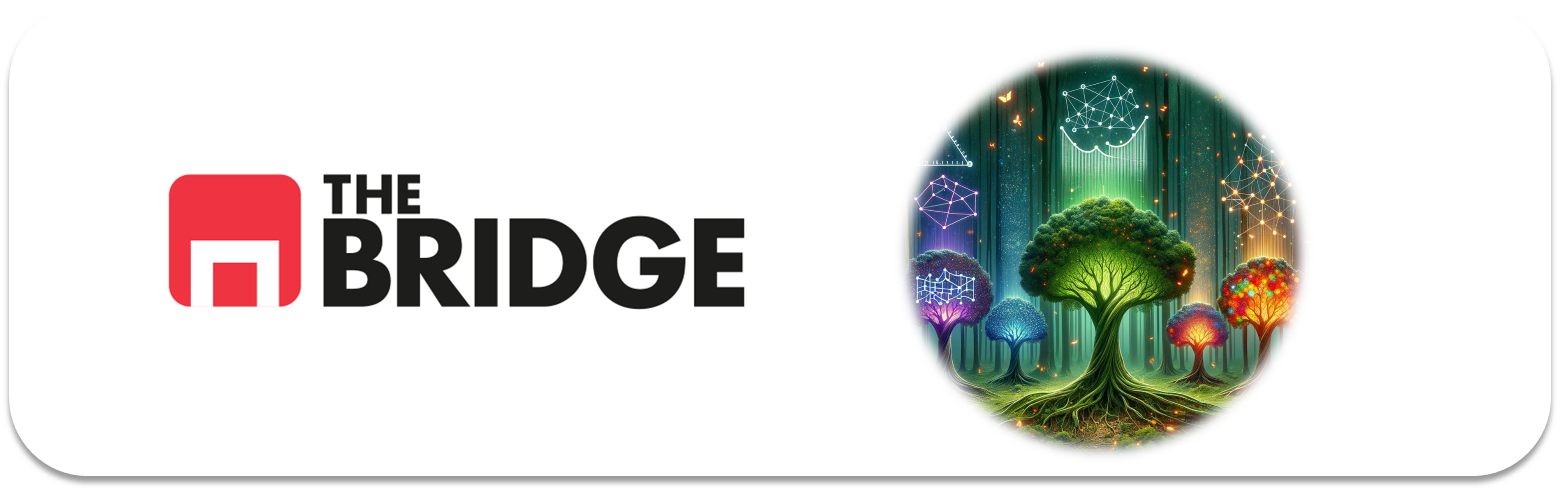

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [ ]:
#Carga y visualización del df
df = pd.read_csv("./data/bank-full.csv",sep=";")
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
#Distribución de la columna target
df["y"].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Limpieza y preprocesamiento de datos

# Paso 2.1: Identificar valores faltantes y manejo de valores "unknown"
# Reemplazamos "unknown" por NaN para identificarlo más fácilmente
df.replace('unknown', np.nan, inplace=True)

# Contamos los valores faltantes en cada columna
print("Valores faltantes por columna:")
print(df.isnull().sum())

Valores faltantes por columna:
age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64


In [ ]:
# Rellenar valores faltantes según el contexto
for col in df.columns:
    if df[col].dtype == 'object':  # Categóricas
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:  # Numéricas
        df[col].fillna(df[col].mean(), inplace=True)

# Paso 2.2: Codificación de variables categóricas
# Definir las columnas categóricas y binarias
binary_columns = ['default', 'housing', 'loan']
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

# Codificación de binarias
for col in binary_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Codificación de variables categóricas con OneHotEncoder
# Usamos ColumnTransformer para aplicar la codificación solo a las columnas categóricas
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
    ],
    remainder='passthrough'  # Deja las columnas no categóricas sin modificar
)

# Aplicar la transformación al DataFrame
processed_data = preprocessor.fit_transform(df)

# Crear un DataFrame procesado con las nuevas columnas
# Recuperamos los nombres de las columnas codificadas
categorical_encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_columns = list(categorical_encoded_columns) + list(df.drop(columns=categorical_columns).columns)
processed_df = pd.DataFrame(processed_data, columns=all_columns)

# Paso 2.3: Escalado de variables numéricas
# Identificamos columnas numéricas
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()
processed_df[numeric_columns] = scaler.fit_transform(processed_df[numeric_columns])

# Mostrar un resumen de los datos procesados
processed_df.head(5)


/var/folders/lc/xsbjt6rs2gq59y6tqrhdjzb40000gn/T/ipykernel_2472/1249229127.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/var/folders/lc/xsbjt6rs2gq59y6tqrhdjzb40000gn/T/ipykernel_2472/1249229127.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.256419,1,0,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,no
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,-0.437895,1,0,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,no
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-0.446762,1,1,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,no
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.047205,1,0,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,no
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,-0.447091,0,0,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,no


In [9]:
from sklearn.model_selection import train_test_split

# Paso 3.1: Separar las características (X) y el target (y)
X = processed_df.drop(columns=['y'])
y = processed_df['y']

# Paso 3.2: Dividir los datos en conjuntos de entrenamiento y prueba
# Usamos un 80% para entrenamiento y un 20% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar el tamaño de los conjuntos resultantes
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

# Verificar la distribución del target en los conjuntos
print("Distribución del target en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))
print("Distribución del target en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))


Tamaño de X_train: (36168, 38)
Tamaño de X_test: (9043, 38)
Tamaño de y_train: (36168,)
Tamaño de y_test: (9043,)
Distribución del target en el conjunto de entrenamiento:
y
no     0.883018
yes    0.116982
Name: proportion, dtype: float64
Distribución del target en el conjunto de prueba:
y
no     0.883003
yes    0.116997
Name: proportion, dtype: float64


Resultados del modelo inicial en el conjunto de entrenamiento:
Accuracy: 1.0000
Reporte de clasificación:
              precision    recall  f1-score   support

          no       1.00      1.00      1.00     31937
         yes       1.00      1.00      1.00      4231

    accuracy                           1.00     36168
   macro avg       1.00      1.00      1.00     36168
weighted avg       1.00      1.00      1.00     36168

Resultados del modelo inicial en el conjunto de prueba:
Accuracy: 0.8633
Reporte de clasificación:
              precision    recall  f1-score   support

          no       0.93      0.92      0.92      7985
         yes       0.42      0.46      0.44      1058

    accuracy                           0.86      9043
   macro avg       0.67      0.69      0.68      9043
weighted avg       0.87      0.86      0.87      9043

Matriz de confusión (conjunto de prueba):
[[7324  661]
 [ 575  483]]


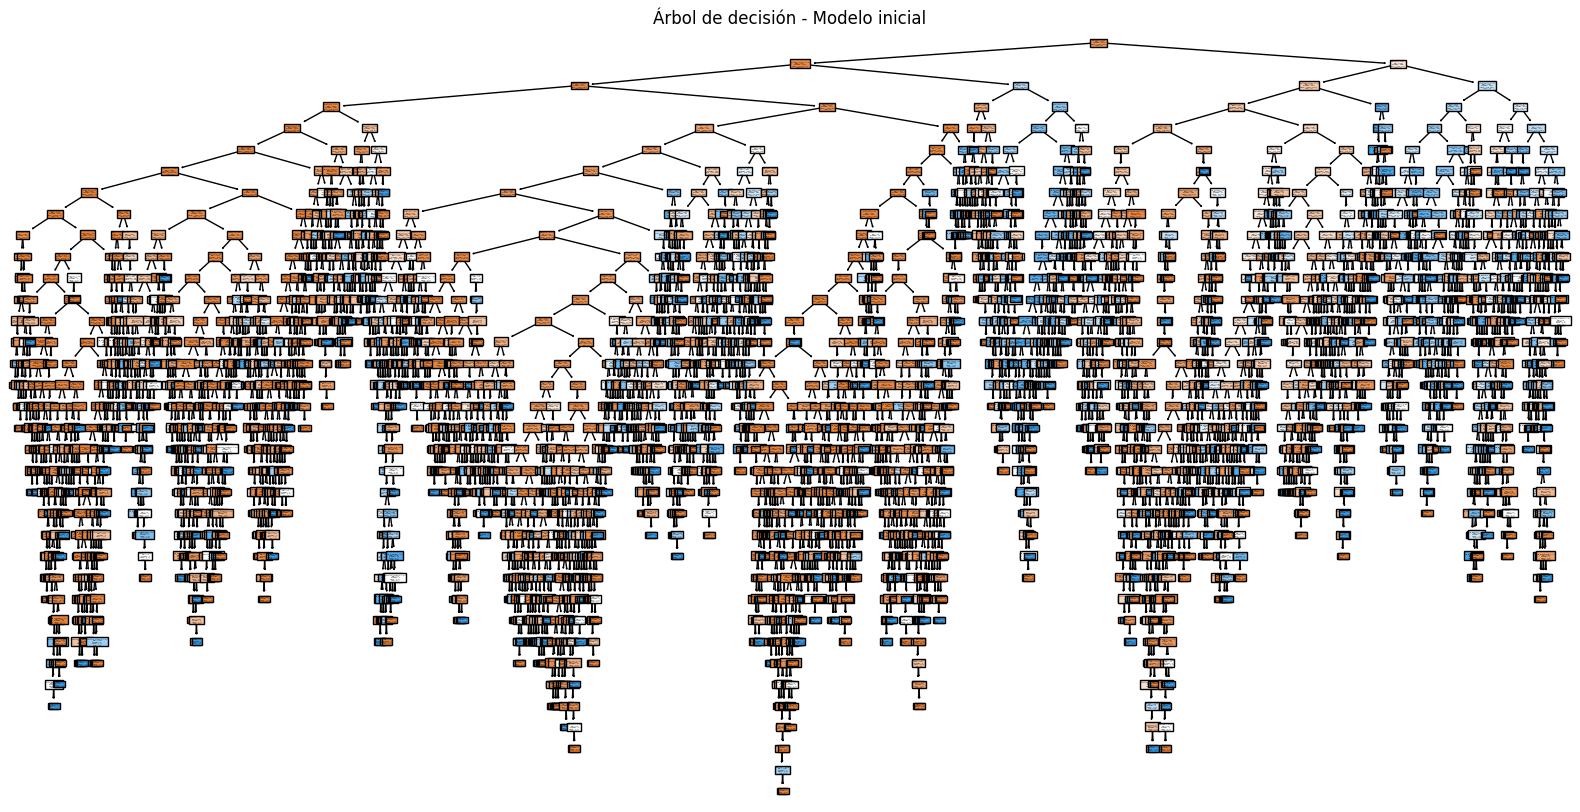

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Paso 4.1: Crear y entrenar el modelo inicial
# Usamos un árbol de decisión con hiperparámetros por defecto
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Paso 4.2: Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = decision_tree.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("Resultados del modelo inicial en el conjunto de entrenamiento:")
print(f"Accuracy: {train_accuracy:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_train, y_train_pred))

# Paso 4.3: Evaluar el modelo en el conjunto de prueba
y_test_pred = decision_tree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Resultados del modelo inicial en el conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_test_pred))

# Paso 4.4: Matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión (conjunto de prueba):")
print(conf_matrix)

# Paso 4.5: Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=X.columns, class_names=["No", "Yes"], filled=True)
plt.title("Árbol de decisión - Modelo inicial")
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Paso 5.1: Definir el modelo base con balanceo de clases
tree_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Paso 5.2: Definir un grid razonado de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 10, 15, None],  # Controla la profundidad del árbol
    'min_samples_split': [2, 5, 10],   # Mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 5, 10],    # Mínimo de muestras en una hoja
    'criterion': ['gini', 'entropy']   # Métricas de partición
}

# Paso 5.3: Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Métrica basada en el balanceo entre clases
    cv=5,                   # Validación cruzada con 5 folds
    n_jobs=-1,              # Usar todos los núcleos disponibles
    verbose=1               # Muestra progreso
)

# Paso 5.4: Entrenar el modelo con la búsqueda en grid
grid_search.fit(X_train, y_train)

# Paso 5.5: Ver los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Paso 5.6: Evaluar el modelo optimizado
best_tree_model = grid_search.best_estimator_

# Evaluación en el conjunto de entrenamiento
y_train_pred = best_tree_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nResultados en el conjunto de entrenamiento:")
print(f"Accuracy: {train_accuracy:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_train, y_train_pred))

# Evaluación en el conjunto de prueba
y_test_pred = best_tree_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nResultados en el conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_test_pred))

# Matriz de confusión en el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nMatriz de confusión (conjunto de prueba):")
print(conf_matrix)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Resultados en el conjunto de entrenamiento:
Accuracy: 1.0000
Reporte de clasificación:
              precision    recall  f1-score   support

          no       1.00      1.00      1.00     31937
         yes       1.00      1.00      1.00      4231

    accuracy                           1.00     36168
   macro avg       1.00      1.00      1.00     36168
weighted avg       1.00      1.00      1.00     36168


Resultados en el conjunto de prueba:
Accuracy: 0.8690
Reporte de clasificación:
              precision    recall  f1-score   support

          no       0.92      0.93      0.93      7985
         yes       0.43      0.40      0.42      1058

    accuracy                           0.87      9043
   macro avg       0.68      0.66      0.67      9043
weighted avg       0.86      0.87      0.8

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Paso 6.1: Crear y entrenar el modelo de regresión logística
# Usamos `class_weight='balanced'` para abordar el desbalance de clases
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train, y_train)

# Paso 6.2: Evaluar el modelo en el conjunto de entrenamiento
y_train_pred_log = logistic_model.predict(X_train)
train_accuracy_log = accuracy_score(y_train, y_train_pred_log)

print("Resultados del modelo de regresión logística en el conjunto de entrenamiento:")
print(f"Accuracy: {train_accuracy_log:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_train, y_train_pred_log))

# Paso 6.3: Evaluar el modelo en el conjunto de prueba
y_test_pred_log = logistic_model.predict(X_test)
test_accuracy_log = accuracy_score(y_test, y_test_pred_log)

print("\nResultados del modelo de regresión logística en el conjunto de prueba:")
print(f"Accuracy: {test_accuracy_log:.4f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_test_pred_log))

# Paso 6.4: Matriz de confusión para el conjunto de prueba
conf_matrix_log = confusion_matrix(y_test, y_test_pred_log)
print("\nMatriz de confusión (conjunto de prueba):")
print(conf_matrix_log)


Resultados del modelo de regresión logística en el conjunto de entrenamiento:
Accuracy: 0.8417
Reporte de clasificación:
              precision    recall  f1-score   support

          no       0.97      0.85      0.90     31937
         yes       0.41      0.81      0.54      4231

    accuracy                           0.84     36168
   macro avg       0.69      0.83      0.72     36168
weighted avg       0.91      0.84      0.86     36168


Resultados del modelo de regresión logística en el conjunto de prueba:
Accuracy: 0.8390
Reporte de clasificación:
              precision    recall  f1-score   support

          no       0.97      0.85      0.90      7985
         yes       0.40      0.79      0.53      1058

    accuracy                           0.84      9043
   macro avg       0.69      0.82      0.72      9043
weighted avg       0.90      0.84      0.86      9043


Matriz de confusión (conjunto de prueba):
[[6754 1231]
 [ 225  833]]


## Conclusiones:

### **Regresión logística:**
- Aunque tiene un menor accuracy general, maneja mucho mejor la clase minoritaria (`yes`) gracias a su mayor recall y F1-score.
- Es un modelo más equilibrado para este problema, ya que prioriza capturar más instancias de la clase minoritaria.

### **Árbol de decisión optimizado:**
- Tiene un mejor accuracy general y buen desempeño en la clase mayoritaria (`no`), pero no logra capturar adecuadamente la clase minoritaria.

### **Elección del modelo:**
- Si la prioridad es capturar a los clientes que aceptan el depósito (`yes`), la **regresión logística** es preferible.
- Si la precisión general es más importante, el **árbol de decisión optimizado** es una mejor opción.
